In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import sys
import os

# Add the project root to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
import boto3, re, json, random, hashlib, math, time, glob
import pandas as pd
import numpy as np
from constants import *
import matplotlib.pyplot as plt
import seaborn as sns
import deferred_acceptance as da
import scripts.setup_data as setup_data
import scripts.experiments as exp

/Users/ElliotKim/opt/anaconda3/envs/llm_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv("../data/final.csv")
model_key = ["Llama", "Mistral", "Claude", "Nova", "Gpt"]
scores_df, with_hand_df = setup_data.filter_and_prepare_data(df)
filtered_columns = [
    col for col in scores_df.columns if any(key in col for key in model_key)
]
C = len(scores_df["Job_index"].unique())
N = len(scores_df["Resume_index"].unique())

resume_dic = {i: idx for i, idx in enumerate(list(scores_df["Resume_index"].unique()))}
job_dic = {i: idx for i, idx in enumerate(list(scores_df["Job_index"].unique()))}

hand_resume_dic = {
    i: idx for i, idx in enumerate(list(with_hand_df["Resume_index"].unique()))
}
hand_job_dic = {
    i: idx for i, idx in enumerate(list(with_hand_df["Job_index"].unique()))
}

firm_models = [col for col in scores_df.columns if "firm" in col and "Hand" not in col]
app_models = [col for col in scores_df.columns if "app" in col and "Hand" not in col]


/Users/ElliotKim/Desktop/Cornell/LLM Markets/llm_labor_market/scripts/setup_data.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores_df[col] = pd.to_numeric(scores_df[col], errors="coerce")
/Users/ElliotKim/Desktop/Cornell/LLM Markets/llm_labor_market/scripts/setup_data.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores_df[cols_to_fill] = scores_df[cols_to_fill].apply(


### Code to generate Figure 4

In [ ]:
company_keywords = ["Llama", "Mistral", "Nova", "Claude", "Gpt"]
experiment_names = (
    ["Firms use Same LLM"]
    + company_keywords
    + ["Latest", "RandomLLM", "RandomCorrelatedLLM", "RandomPref"]
)
trials = 1500

buckets = np.arange(0, 10, 1)
rows = []
uniformly_random_dic, llm_dic = (
    {experiment: [[] for _ in buckets] for experiment in experiment_names}
    for _ in range(2)
)
for i in range(trials):
    start = time.time()
    # Number of jobs that are hand labelled, since we hand labelled a subset of 15 jobs and 30 resumes
    job = random.randint(0, 14)
    t = exp.add_noise(with_hand_df, filtered_columns, use_hand=True)
    firm_hand_vals = list(t[t["Job_index"] == hand_job_dic[job]]["Hand_firm_rate_comb"])

    f_rank_df = exp.generate_llm_firm_pref(
        exp.add_noise(with_hand_df, filtered_columns, use_hand=True), firm_models
    )
    # uniformly random applicant pref
    human_dic = {experiment: [[] for _ in buckets] for experiment in experiment_names}
    a_rank_df = exp.generate_random_applicant_pref(
        exp.add_noise(with_hand_df, filtered_columns, use_hand=True), app_models
    )
    app_cols = random.sample(list(a_rank_df.iloc[:, 1:].columns), len(firm_hand_vals))
    vals = exp.run_firm_experiments(
        scores_df,
        firm_models,
        filtered_columns,
        a_rank_df,
        app_cols,
        f_rank_df,
        with_hand_df,
        diff=False,
        human=True,
        firm_hand_vals=firm_hand_vals,
        human_dic=human_dic,
        job=job,
    )
    for experiment in experiment_names:
        for bucket_index, results in enumerate(vals[0][experiment]):
            if results:
                avg = sum(results) / len(results)
                uniformly_random_dic[experiment][bucket_index].append(avg)
    vals[1]["Applicant Preference Method"] = "Uniformly Random"
    rows.append(vals[1])
    # Applicant Preferences Determined by LLMs
    human_dic = {experiment: [[] for _ in buckets] for experiment in experiment_names}
    a_rank_df = exp.generate_llm_applicant_pref(
        exp.add_noise(with_hand_df, filtered_columns, use_hand=True), app_models
    )
    app_cols = [col for col in a_rank_df.columns if "Llama3-1-405b" in col]
    vals = exp.run_firm_experiments(
        scores_df,
        firm_models,
        filtered_columns,
        a_rank_df,
        app_cols,
        f_rank_df,
        with_hand_df,
        diff=False,
        human=True,
        firm_hand_vals=firm_hand_vals,
        human_dic=human_dic,
        job=job,
    )
    for experiment in experiment_names:
        for bucket_index, results in enumerate(vals[0][experiment]):
            if results:
                avg = sum(results) / len(results)
                llm_dic[experiment][bucket_index].append(avg)
    vals[1]["Applicant Preference Method"] = "LLM"
    rows.append(vals[1])
    end = time.time()
    print(f"Trial {i}: {end-start}")

homog_hand_no_diff_df = pd.DataFrame(rows)
homog_hand_llm_dic_df = pd.DataFrame(llm_dic)
homog_hand_uniformly_random_dic_df = pd.DataFrame(uniformly_random_dic)

company_keywords = ["Llama", "Mistral", "Nova", "Claude", "Gpt"]

homog_hand_llm_dic_df["Firms Same Company LLM"] = homog_hand_llm_dic_df[
    company_keywords
].sum(axis=1)
homog_hand_uniformly_random_dic_df["Firms Same Company LLM"] = (
    homog_hand_uniformly_random_dic_df[company_keywords].sum(axis=1)
)


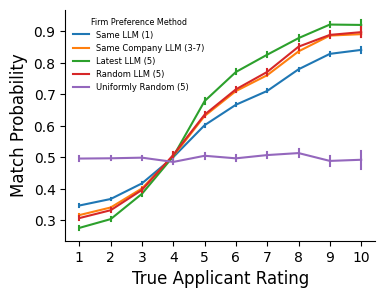

In [ ]:
long_format_data = []
experiment_names = [
    "Firms use Same LLM",
    "Firms Same Company LLM",
    "Latest",
    "RandomLLM",
    "RandomPref",
]
plot_experiment_names = [
    "Same LLM",
    "Same Company LLM",
    "Latest LLM",
    "Random LLM",
    "Uniformly Random",
]
homog_hand_llm_dic_df.rename(
    columns={t1: t2 for t1, t2 in zip(experiment_names, plot_experiment_names)},
    inplace=True,
)
for index, row in homog_hand_llm_dic_df[plot_experiment_names].iterrows():
    for column in plot_experiment_names:
        values = row[column]
        for value in values:
            long_format_data.append((index + 1, column, value))

# Convert to DataFrame
plot_df1 = pd.DataFrame(
    long_format_data, columns=["True Percentile", "Experiment", "Value"]
)
# plot_df1['True Percentile'] /= 10
# Plot the scaled data
plt.figure(figsize=(4, 3))
ax = sns.lineplot(
    data=plot_df1,
    x="True Percentile",
    y="Value",
    hue="Experiment",
    err_style="bars",
    errorbar="se",
)
plt.xticks(range(1, 11, 1))
# Labels and formatting
plt.xlabel("True Applicant Rating", fontsize=12)
plt.ylabel("Match Probability", fontsize=12)
legend = plt.legend(
    title="Firm Preference Method",
    prop={'size': 6},
    frameon=False
)

legend_labels = {
    "Same LLM": "Same LLM (1)",
    "Same Company LLM": "Same Company LLM (3-7)",
    "Latest LLM": "Latest LLM (5)",
    "Random LLM": "Random LLM (5)",
    "Uniformly Random": "Uniformly Random (5)"
}
# Rename legend labels
handles, labels = ax.get_legend_handles_labels()
new_labels = [legend_labels[label] for label in labels]
for text, new_label in zip(legend.get_texts(), new_labels):
    text.set_text(new_label)
plt.setp(legend.get_title(), fontsize="xx-small")
sns.despine()
plt.savefig(
    f"../final_figures/4.6_f_llm_match_prob_true_rating.pdf", dpi=3000, bbox_inches="tight"
)
plt.show()


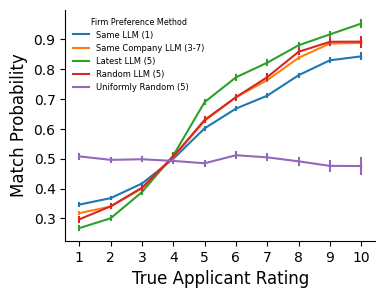

In [ ]:
long_format_data = []
experiment_names = [
    "Firms use Same LLM",
    "Firms Same Company LLM",
    "Latest",
    "RandomLLM",
    "RandomPref",
]
plot_experiment_names = [
    "Same LLM",
    "Same Company LLM",
    "Latest LLM",
    "Random LLM",
    "Uniformly Random",
]
homog_hand_uniformly_random_dic_df.rename(
    columns={t1: t2 for t1, t2 in zip(experiment_names, plot_experiment_names)},
    inplace=True,
)
for index, row in homog_hand_uniformly_random_dic_df[plot_experiment_names].iterrows():
    for column in plot_experiment_names:
        values = row[column]
        for value in values:
            long_format_data.append((index + 1, column, value))

# Convert to DataFrame
plot_df1 = pd.DataFrame(
    long_format_data, columns=["True Percentile", "Experiment", "Value"]
)
# plot_df1['True Percentile'] /= 10
# Plot the scaled data
plt.figure(figsize=(4, 3))
ax = sns.lineplot(
    data=plot_df1,
    x="True Percentile",
    y="Value",
    hue="Experiment",
    err_style="bars",
    errorbar="se",
)
plt.xticks(range(1, 11, 1))
# Labels and formatting
plt.xlabel("True Applicant Rating", fontsize=12)
plt.ylabel("Match Probability", fontsize=12)
legend = plt.legend(
    title="Firm Preference Method",
    prop={'size': 6},
    frameon=False
)

legend_labels = {
    "Same LLM": "Same LLM (1)",
    "Same Company LLM": "Same Company LLM (3-7)",
    "Latest LLM": "Latest LLM (5)",
    "Random LLM": "Random LLM (5)",
    "Uniformly Random": "Uniformly Random (5)"
}
# Rename legend labels
handles, labels = ax.get_legend_handles_labels()
new_labels = [legend_labels[label] for label in labels]
for text, new_label in zip(legend.get_texts(), new_labels):
    text.set_text(new_label)
plt.setp(legend.get_title(), fontsize="xx-small")
sns.despine()
plt.savefig(
    f"../final_figures/4.6_f_random_match_prob_true_rating.pdf",
    dpi=3000,
    bbox_inches="tight",
)
plt.show()


### Code to generate Figure 5a (LLM determined applicant-preference in Figure 10)

In [ ]:
trials = 1500
rows = []
for i in range(trials):
    start = time.time()
    job = random.randint(0, C - 1)
    f_rank_df = exp.generate_llm_firm_pref(
        exp.add_noise(scores_df, filtered_columns), firm_models
    )
    # uniformly random applicant pref
    a_rank_df = exp.generate_random_applicant_pref(
        exp.add_noise(scores_df, filtered_columns), app_models
    )
    app_cols = random.sample(list(a_rank_df.iloc[:, 1:].columns), N)
    vals = exp.run_firm_experiments(
        scores_df,
        firm_models,
        filtered_columns,
        a_rank_df,
        app_cols,
        f_rank_df,
        with_hand_df,
        job=job,
        diff=False,
        human=False,
    )
    vals["Applicant Preference Method"] = "Uniformly Random"
    rows.append(vals)
    # Applicant Preferences Determined by LLMs
    a_rank_df = exp.generate_llm_applicant_pref(
        exp.add_noise(scores_df, filtered_columns), app_models
    )
    app_cols = [col for col in a_rank_df.columns if "Llama3-1-405b" in col]
    vals = exp.run_firm_experiments(
        scores_df,
        firm_models,
        filtered_columns,
        a_rank_df,
        app_cols,
        f_rank_df,
        with_hand_df,
        job=job,
        diff=False,
        human=False,
    )
    vals["Applicant Preference Method"] = "LLM"
    rows.append(vals)
    end = time.time()
    print(f"Trial {i}: {end-start}")
homog_no_diff_df = pd.DataFrame(rows)


In [21]:
company_keywords = ["Llama", "Mistral", "Nova", "Claude", "Gpt"]
homog_no_diff_df["Firms Same Company LLM_Firm Rank"] = 0
homog_no_diff_df["Firms Same Company LLM_Applicant Rank"] = 0
for company in company_keywords:
    homog_no_diff_df["Firms Same Company LLM_Firm Rank"] += homog_no_diff_df[
        f"{company}_Firm Rank"
    ]
    homog_no_diff_df["Firms Same Company LLM_Applicant Rank"] += homog_no_diff_df[
        f"{company}_Applicant Rank"
    ]
homog_no_diff_df["Firms Same Company LLM_Firm Rank"] = homog_no_diff_df[
    "Firms Same Company LLM_Firm Rank"
] / len(company_keywords)
homog_no_diff_df["Firms Same Company LLM_Applicant Rank"] = homog_no_diff_df[
    "Firms Same Company LLM_Applicant Rank"
] / len(company_keywords)


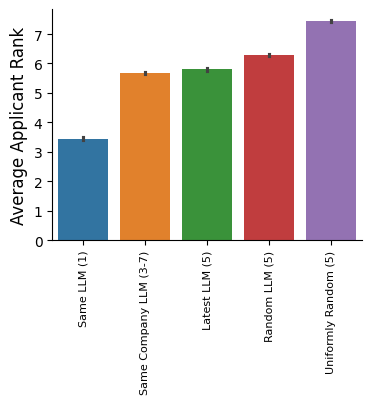

In [ ]:
plt.figure(figsize=(4,3))
experiment_names = ['Firms use Same LLM', 'Firms Same Company LLM', 'Latest', 'RandomLLM', 'RandomPref']
applicant_rank_cols = [f"{col}_Applicant Rank" for col in experiment_names]
plot_df = homog_no_diff_df[homog_no_diff_df['Applicant Preference Method']=="Uniformly Random"][applicant_rank_cols]

sns.barplot(
    data=plot_df, 
    errorbar="se",
)
plt.xticks(
    ticks=range(len(experiment_names)),  # Match the number of bars
    labels=['Same LLM (1)', 'Same Company LLM (3-7)', 'Latest LLM (5)', 'Random LLM (5)', 'Uniformly Random (5)'],
    fontsize=8,
    rotation=90
)
# plt.title("Average Applicant Rank (Applicant Preference Method = LLM)")
plt.ylabel("Average Applicant Rank", fontsize=12)
plt.xticks(fontsize=8)
sns.despine()
plt.savefig(f'../final_figures/4.6_f2_avg_app_rank_random.pdf', dpi=3000, bbox_inches="tight")
plt.show()

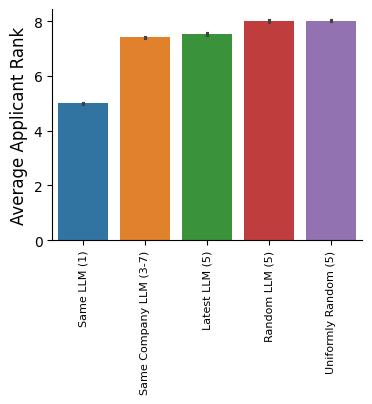

In [ ]:
plt.figure(figsize=(4,3))
experiment_names = ['Firms use Same LLM', 'Firms Same Company LLM', 'Latest', 'RandomLLM', 'RandomPref']
applicant_rank_cols = [f"{col}_Applicant Rank" for col in experiment_names]
plot_df = homog_no_diff_df[homog_no_diff_df['Applicant Preference Method']=="LLM"][applicant_rank_cols]

sns.barplot(
    data=plot_df,  
    errorbar="se",
)
# plt.title("Average Applicant Rank (Applicant Preference Method = Uniformly Random)")
plt.ylabel("Average Applicant Rank", fontsize=12)
plt.xticks(
    ticks=range(len(experiment_names)),  # Match the number of bars
    labels=['Same LLM (1)', 'Same Company LLM (3-7)', 'Latest LLM (5)', 'Random LLM (5)', 'Uniformly Random (5)'],
    fontsize=8,
    rotation=90
)
sns.despine()
plt.savefig(f'../final_figures/4.6_f2_avg_app_rank_llm.pdf', dpi=3000, bbox_inches="tight")
plt.show()

### Code to generate Figure 5b (LLM determined applicant-preference in Figure 10)

In [ ]:
company_keywords = ["Llama", "Mistral", "Nova", "Claude", "Gpt"]
experiment_names = (
    ["Firms use Same LLM"]
    + company_keywords
    + ["Latest", "RandomLLM", "RandomCorrelatedLLM", "RandomPref"]
)
buckets = range(1, C + 1)
trials = 1500
uniformly_random_dic, llm_dic = (
    {experiment: [[] for _ in buckets] for experiment in experiment_names}
    for _ in range(2)
)
for i in range(trials):
    job = random.randint(0, C - 1)
    start = time.time()
    f_rank_df = exp.generate_llm_firm_pref(
        exp.add_noise(scores_df, filtered_columns), firm_models
    )
    # uniformly random applicant pref
    diff_dic = {experiment: [[] for _ in buckets] for experiment in experiment_names}
    a_rank_df = exp.generate_random_applicant_pref(
        exp.add_noise(scores_df, filtered_columns), app_models
    )
    app_cols = random.sample(list(a_rank_df.iloc[:, 1:].columns), N)
    vals = exp.run_firm_experiments(
        scores_df,
        firm_models,
        filtered_columns,
        a_rank_df,
        app_cols,
        f_rank_df,
        with_hand_df,
        diff_dic=diff_dic,
        job=job,
        diff=2,
        human=False,
    )
    for experiment in experiment_names:
        for bucket_index, results in enumerate(vals[experiment]):
            avg = sum(results) / len(results) if results else 0.0
            uniformly_random_dic[experiment][bucket_index].append(avg)
    # Applicant Preferences Determined by LLMs
    diff_dic = {experiment: [[] for _ in buckets] for experiment in experiment_names}
    a_rank_df = exp.generate_llm_applicant_pref(
        exp.add_noise(scores_df, filtered_columns), app_models
    )
    app_cols = [col for col in a_rank_df.columns if "Llama3-1-405b" in col]
    vals = exp.run_firm_experiments(
        scores_df, 
        firm_models,
        filtered_columns,
        a_rank_df,
        app_cols,
        f_rank_df,
        with_hand_df,
        diff_dic=diff_dic,
        job=job,
        diff=2,
        human=False,
    )
    for experiment in experiment_names:
        for bucket_index, results in enumerate(vals[experiment]):
            avg = sum(results) / len(results) if results else 0.0
            llm_dic[experiment][bucket_index].append(avg)
    end = time.time()
    print(f"Trial {i}: {end-start}")

homog_llm_dic_df = pd.DataFrame(llm_dic)
homog_uniformly_random_dic_df = pd.DataFrame(uniformly_random_dic)
company_keywords = ["Llama", "Mistral", "Nova", "Claude", "Gpt"]

homog_llm_dic_df["Firms Same Company LLM"] = homog_llm_dic_df[company_keywords].sum(
    axis=1
)
homog_uniformly_random_dic_df["Firms Same Company LLM"] = homog_uniformly_random_dic_df[
    company_keywords
].sum(axis=1)


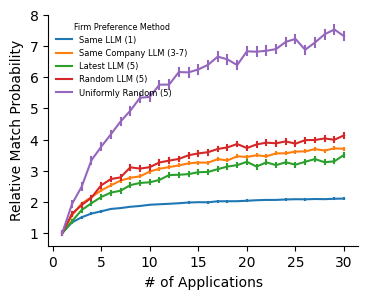

In [ ]:
long_format_data = []
experiment_names = [
    "Firms use Same LLM",
    "Firms Same Company LLM",
    "Latest",
    "RandomLLM",
    "RandomPref",
]
plot_experiment_names = [
    "Same LLM",
    "Same Company LLM",
    "Latest LLM",
    "Random LLM",
    "Uniformly Random",
]
homog_uniformly_random_dic_df.rename(
    columns={t1: t2 for t1, t2 in zip(experiment_names, plot_experiment_names)},
    inplace=True,
)
for index, row in homog_uniformly_random_dic_df[plot_experiment_names].iterrows():
    for column in plot_experiment_names:
        values = row[column]
        for value in values:
            long_format_data.append((index + 1, column, value))

# Convert to DataFrame
plot_df = pd.DataFrame(
    long_format_data, columns=["Jobs Applied", "Experiment", "Value"]
)

initial_values = (
    plot_df[plot_df["Jobs Applied"] == 1].groupby("Experiment")["Value"].mean()
)

# Scale the values by dividing by the initial value for each experiment
plot_df["Scaled Value"] = plot_df.apply(
    lambda row: row["Value"] / initial_values[row["Experiment"]], axis=1
)

# Plot the scaled data
plt.figure(figsize=(4, 3))
ax = sns.lineplot(
    data=plot_df,
    x="Jobs Applied",
    y="Scaled Value",
    hue="Experiment",
    err_style="bars",
    errorbar="se"
)

# Labels and formatting
plt.xlabel("# of Applications")
plt.ylabel("Relative Match Probability")
legend = plt.legend(
    title="Firm Preference Method",
    prop={'size': 6},
    frameon=False
)

legend_labels = {
    "Same LLM": "Same LLM (1)",
    "Same Company LLM": "Same Company LLM (3-7)",
    "Latest LLM": "Latest LLM (5)",
    "Random LLM": "Random LLM (5)",
    "Uniformly Random": "Uniformly Random (5)"
}
# Rename legend labels
handles, labels = ax.get_legend_handles_labels()
new_labels = [legend_labels[label] for label in labels]
for text, new_label in zip(legend.get_texts(), new_labels):
    text.set_text(new_label)
plt.setp(legend.get_title(), fontsize="xx-small")
sns.despine()
plt.savefig(
    f"../final_figures/4.6_f_random_match_prob_jobs_applied_scaled.pdf",
    dpi=3000,
    bbox_inches="tight",
)
plt.show()


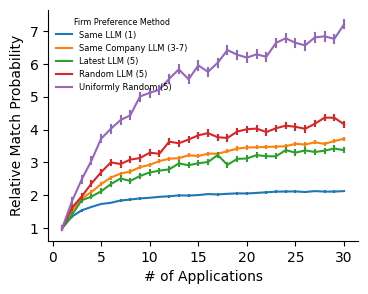

In [ ]:
long_format_data = []
experiment_names = ['Firms use Same LLM', 'Firms Same Company LLM', 'Latest', 'RandomLLM', 'RandomPref']
plot_experiment_names = ['Same LLM', 'Same Company LLM', 'Latest LLM', 'Random LLM', 'Uniformly Random']
homog_llm_dic_df.rename(columns={t1:t2 for t1,t2 in zip(experiment_names, plot_experiment_names)}, inplace=True)
for index, row in homog_llm_dic_df[plot_experiment_names].iterrows():
    for column in plot_experiment_names:
        values = row[column]
        for value in values:
            long_format_data.append((index+1, column, value))

# Convert to DataFrame
plot_df = pd.DataFrame(long_format_data, columns=["Jobs Applied", "Experiment", "Value"])
initial_values = plot_df[plot_df["Jobs Applied"] == 1].groupby("Experiment")["Value"].mean()

# Scale the values by dividing by the initial value for each experiment
plot_df["Scaled Value"] = plot_df.apply(
    lambda row: row["Value"] / initial_values[row["Experiment"]], axis=1
)

# Plot the scaled data
plt.figure(figsize=(4, 3))
ax = sns.lineplot(
    data=plot_df,
    x="Jobs Applied",
    y="Scaled Value",
    hue="Experiment",
    err_style="bars",
    errorbar="se"
)

# Labels and formatting
plt.xlabel("# of Applications")
plt.ylabel("Relative Match Probability")
legend = plt.legend(
    title="Firm Preference Method",
    prop={'size': 6},
    frameon=False
)

legend_labels = {
    "Same LLM": "Same LLM (1)",
    "Same Company LLM": "Same Company LLM (3-7)",
    "Latest LLM": "Latest LLM (5)",
    "Random LLM": "Random LLM (5)",
    "Uniformly Random": "Uniformly Random (5)"
}
# Rename legend labels
handles, labels = ax.get_legend_handles_labels()
new_labels = [legend_labels[label] for label in labels]
for text, new_label in zip(legend.get_texts(), new_labels):
    text.set_text(new_label)

plt.setp(legend.get_title(), fontsize='xx-small')
sns.despine()
plt.savefig(f'../final_figures/4.6_f_llm_match_prob_jobs_applied_scaled.pdf', dpi=3000, bbox_inches="tight")
plt.show()